<a href="https://colab.research.google.com/github/Kp-bishi/New/blob/main/Personalized_Treatment_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install gdown

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import gdown


# Download the file from Google Drive using gdown
# Replace with your own file ID
file_id = '1WLN55xiLpnyKB9civlvXqUwAiBYLKEci'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'personalized_treatment_recommendation.csv'
gdown.download(url, output, quiet=False)

# Load the data
df = pd.read_csv(output)  # Or use your local path: "/content/drive/MyDrive/personalized_treatment_recommendation.csv"

#Preprocess & Clean Data
# Overview
print(df.head())
print(df.info())
print(df.isnull().sum())

# Handle missing values (basic strategy: drop or fill)
df = df.dropna()  # or use df.fillna(method='ffill') as an alternative

# Encode categorical features
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Final check
print(df.head())


Downloading...
From: https://drive.google.com/uc?id=1WLN55xiLpnyKB9civlvXqUwAiBYLKEci
To: /content/personalized_treatment_recommendation.csv
100%|██████████| 13.7k/13.7k [00:00<00:00, 27.6MB/s]

  Patient_ID  Age  Gender   Diagnosis Allergies       Past_Treatments  \
0       P001   30    Male      Asthma       NaN            Omeprazole   
1       P002   58    Male    Diabetes     Sulfa            Amlodipine   
2       P003   72    Male  Depression    NSAIDs  Metformin, Glipizide   
3       P004   49    Male      Asthma     Sulfa             Albuterol   
4       P005   72  Female      Asthma       NaN               Insulin   

                      Current_Symptoms Risk_Level Recommended_Drug Dosage  \
0  ['Shortness of Breath', 'Headache']       High       Prednisone   75mg   
1                ['Nausea', 'Anxiety']     Medium      Sitagliptin   72mg   
2           ['Palpitations', 'Nausea']     Medium       Sertraline   96mg   
3     ['Cough', 'Shortness of Breath']        Low      Montelukast   99mg   
4            ['Palpitations', 'Cough']        Low      Montelukast   26mg   

                    Notes   BMI Smoker   Chronic_Conditions  
0  Needs liver monitoring  24.1     

In [18]:
#Feature Engineering
# Define target column
target_col = 'Recommended_Drug'

# Separate features and target
X = df.drop(columns=[target_col, 'Patient_ID', 'Notes'])  # Drop ID/notes as they’re not useful
y = df[target_col]

# Encode categorical columns
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Encode the target column
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)

# Split data
from sklearn.model_selection import train_test_split
# Remove stratify parameter or handle classes with single instances
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
    # stratify=y  # Remove or handle classes with 1 instance
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (37, 11)
Test shape: (10, 11)


In [19]:
#Build a Classifier (RandomForest/XGBoost)
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           6       1.00      0.50      0.67         2
           7       1.00      1.00      1.00         2
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         2
          11       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1

    accuracy                           0.50        10
   macro avg       0.44      0.39      0.41        10
weighted avg       0.60      0.50      0.53        10



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:01:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels w

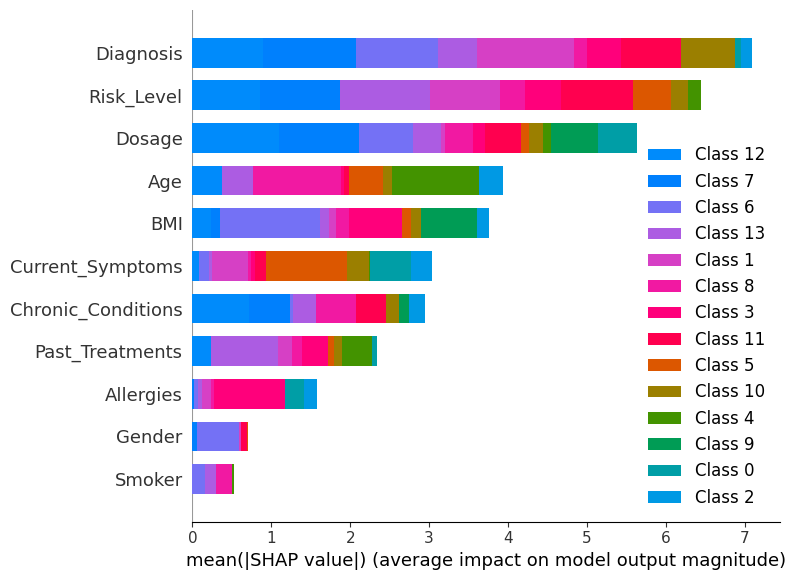

In [20]:
#Evaluate & Interpret the Model
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")
